# Subset Selection Methods

## Best Subset Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import statsmodels.api as sm

%matplotlib inline

In [2]:


#read the data and drop null values
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0, na_values='NA').dropna()
hitters = pd.get_dummies(hitters, drop_first=True)

X = hitters[hitters.columns.drop('Salary')]
y = hitters['Salary']

#if using statsmodels.api.OLS need to add a constant so intercept is calculated
#also statsmodels.api.OLS is 3-4 times faster than statsmodels.formula.api.ols
X = sm.add_constant(X)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#best subset selection - takes about 10 minutes
bss_models = {}

TIC = time.time()

for i in range(1, len(X.columns)):
    tic = time.time()
    #this counter will count the number of models that are fitted
    ctr = 0
    #reset the minimum rss each iteration
    min_rss = 1e100
    #loop through combinations of variables ('const' stays in every model - intercept)
    for combo in itertools.combinations(X.columns.drop('const'), i):
        #fit the model with the constant and combo of variables
        lr = sm.OLS(y, X[['const'] + list(combo)]).fit()
        #calculate the RSS
        calc_rss = ((lr.predict() - y) ** 2).sum()
        #check if the calculated RSS is less than previous minimum
        if calc_rss < min_rss:
            min_rss = calc_rss
            min_model = lr
        ctr += 1
    #at the end of the loop, add the best model to the dictionary along with its RSS
    bss_models[i] = [min_model, min_rss]
    toc = time.time()
    print('Processed {} models on {} predictors in {} seconds' \
          .format(ctr, i, toc-tic))
    
TOC = time.time()
print('\nTotal elapsed time: {} seconds'.format(TOC-TIC))

Processed 19 models on 1 predictors in 0.020000934600830078 seconds
Processed 171 models on 2 predictors in 0.16200947761535645 seconds
Processed 969 models on 3 predictors in 0.9330530166625977 seconds
Processed 3876 models on 4 predictors in 3.801217555999756 seconds
Processed 11628 models on 5 predictors in 11.69166874885559 seconds
Processed 27132 models on 6 predictors in 27.36356520652771 seconds
Processed 50388 models on 7 predictors in 51.936970710754395 seconds
Processed 75582 models on 8 predictors in 78.84950995445251 seconds
Processed 92378 models on 9 predictors in 97.7895929813385 seconds
Processed 92378 models on 10 predictors in 99.76870656013489 seconds
Processed 75582 models on 11 predictors in 83.3337664604187 seconds
Processed 50388 models on 12 predictors in 56.25821781158447 seconds
Processed 27132 models on 13 predictors in 30.794761180877686 seconds
Processed 11628 models on 14 predictors in 13.437768459320068 seconds
Processed 3876 models on 15 predictors in 4.

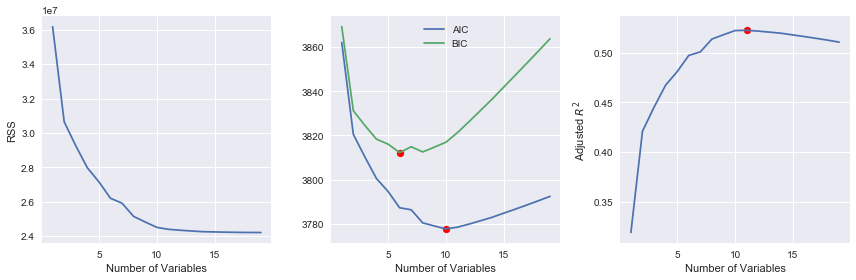

In [4]:
indices = sorted(list(bss_models.keys()))

aic = np.array([])
bic = np.array([])
adj_r2 = np.array([])
rss = np.array([])


for i in range(1, len(bss_models)+1):
    aic = np.append(aic, bss_models[i][0].aic)
    bic = np.append(bic, bss_models[i][0].bic)
    adj_r2 = np.append(adj_r2, bss_models[i][0].rsquared_adj)
    rss = np.append(rss, bss_models[i][1])
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(indices, rss)
ax1.set(xlabel='Number of Variables', ylabel='RSS')

ax2.plot(indices, aic)
ax2.plot(indices, bic)
ax2.legend(['AIC', 'BIC'], loc=9)
ax2.scatter(aic.argmin()+1, aic[aic.argmin()], c='r')
ax2.scatter(bic.argmin()+1, bic[bic.argmin()], c='r')
ax2.set(xlabel='Number of Variables')

ax3.plot(indices, adj_r2)
ax3.scatter(adj_r2.argmax()+1, adj_r2[adj_r2.argmax()], c='r')
ax3.set(xlabel='Number of Variables', ylabel=r'Adjusted $R^2$');

fig.tight_layout()

## Forward and Backward Stepwise Selection

In [5]:
#forward selection

unused_vars = X.columns.drop('const')
model_vars = []
fs_models = {}

for i in range(len(unused_vars)):
    min_rss = 1e100
    for v in unused_vars:
        lr = sm.OLS(y, X[['const'] + list(model_vars) + [v]]).fit()
        calc_rss = ((lr.predict() - y) ** 2).sum()
        if calc_rss < min_rss:
            min_rss = calc_rss
            min_model = lr
            min_var = v
    model_vars.append(min_var)
    unused_vars = unused_vars.drop(min_var)
    fs_models[i+1] = [min_model, min_rss]

In [6]:
#backward selection
model_vars = X.columns.drop('const')
omitted_vars = []
bs_models = {}

for i in range(len(model_vars), 0, -1):
    lr = sm.OLS(y, X[['const'] + list(model_vars)]).fit()
    calc_rss = ((lr.predict() - y) ** 2).sum()
    bs_models[i] = [lr, calc_rss]
    min_rss = 1e100
    if len(model_vars) > 1:
        for v in model_vars:
            lr = sm.OLS(y, X[['const'] + list(model_vars.drop(v))]).fit()
            calc_rss = ((lr.predict() - y) ** 2).sum()
            if calc_rss < min_rss:
                min_rss = calc_rss
                min_var = v
        model_vars = model_vars.drop(min_var)

In [7]:
ind = 7

print('{} Variable(s)\n-------------'.format(ind))
print('Best subset selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(bss_models[ind][0].params.index.drop('const')), 
              bss_models[ind][1]))
print('Forward selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(fs_models[ind][0].params.index.drop('const')), fs_models[ind][1]))
print('Backward selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(bs_models[ind][0].params.index.drop('const')), bs_models[ind][1]))

7 Variable(s)
-------------
Best subset selection
	Variables: ['Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W']
	RSS: 25906547.500623748

Forward selection
	Variables: ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']
	RSS: 25954217.081713855

Backward selection
	Variables: ['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts', 'Division_W']
	RSS: 25933487.446485594



## Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [8]:
#best subset selection with validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

bss_val_models = {}
bss_val_mse = {}

TIC = time.time()

for i in range(1, len(X.columns)):
    tic = time.time()
    #this counter will count the number of models that are fitted
    ctr = 0
    #reset the minimum rss each iteration
    min_rss = 1e100
    #loop through combinations of variables ('const' stays in every model - intercept)
    for combo in itertools.combinations(X.columns.drop('const'), i):
        #fit the model with the constant and combo of variables
        lr = sm.OLS(y_train, X_train[['const'] + list(combo)]).fit()
        #calculate the test error (MSE)
        calc_rss = ((lr.predict() - y_train) ** 2).sum()
        #check if the calculated RSS is less than previous minimum
        if calc_rss < min_rss:
            min_rss = calc_rss
            min_model = lr
            min_combo = combo
        ctr += 1
    #at the end of the loop, add the best model to the dictionary along with its RSS
    bss_val_models[i] = [min_model, min_rss]
    #now calculate the mse on the test set
    bss_val_mse[i] = ((min_model.predict(exog=X_test[['const'] + list(min_combo)]) - y_test) ** 2).mean()
    toc = time.time()
    print('Processed {} models on {} predictors in {} seconds' \
          .format(ctr, i, toc-tic))
    
TOC = time.time()
print('\nTotal elapsed time: {} seconds'.format(TOC-TIC))

m = min(bss_val_mse.values())
for k in bss_val_mse.keys():
    if bss_val_mse[k] == m:
        print('\nBest Model (lowest MSE):\nNumber of Variables: {}\nMSE: {:.4f}'.format(k, m))
        print('Model Variables: {}'.format(list(bss_val_models[k][0].params.index.drop('const'))))

Processed 19 models on 1 predictors in 0.02000117301940918 seconds
Processed 171 models on 2 predictors in 0.16400933265686035 seconds
Processed 969 models on 3 predictors in 0.941054105758667 seconds
Processed 3876 models on 4 predictors in 3.808217763900757 seconds
Processed 11628 models on 5 predictors in 11.57566213607788 seconds
Processed 27132 models on 6 predictors in 27.311562061309814 seconds
Processed 50388 models on 7 predictors in 51.30493450164795 seconds
Processed 75582 models on 8 predictors in 77.96645951271057 seconds
Processed 92378 models on 9 predictors in 96.39751362800598 seconds
Processed 92378 models on 10 predictors in 97.9256010055542 seconds
Processed 75582 models on 11 predictors in 80.76961970329285 seconds
Processed 50388 models on 12 predictors in 54.764132499694824 seconds
Processed 27132 models on 13 predictors in 29.99171543121338 seconds
Processed 11628 models on 14 predictors in 13.073747873306274 seconds
Processed 3876 models on 15 predictors in 4.4

In [9]:
#forward selection with validation set

unused_vars = X.columns.drop('const')
model_vars = []
fs_val_models = {}
fs_val_mse = {}

for i in range(len(unused_vars)):
    min_rss = 1e100
    for v in unused_vars:
        lr = sm.OLS(y_train, X_train[['const'] + list(model_vars) + [v]]).fit()
        calc_rss = ((lr.predict() - y_train) ** 2).sum()
        if calc_rss < min_rss:
            min_rss = calc_rss
            min_model = lr
            min_var = v
    model_vars.append(min_var)
    unused_vars = unused_vars.drop(min_var)
    fs_val_models[i+1] = [min_model, min_rss]
    fs_val_mse[i+1] = ((min_model.predict(exog=X_test[['const'] + list(model_vars)]) - y_test) ** 2).mean()
    
m = min(fs_val_mse.values())
for k in fs_val_mse.keys():
    if fs_val_mse[k] == m:
        print('Best Model (lowest MSE):\nNumber of Variables: {}\nMSE: {:.4f}'.format(k, m))
        print('Model Variables: {}'.format(list(fs_val_models[k][0].params.index.drop('const'))))

Best Model (lowest MSE):
Number of Variables: 5
MSE: 104319.5326
Model Variables: ['CRBI', 'PutOuts', 'Walks', 'Division_W', 'Hits']


In [10]:
#backward selection with validation set

model_vars = X.columns.drop('const')
omitted_vars = []
bs_val_models = {}
bs_val_mse = {}

for i in range(len(model_vars), 0, -1):
    lr = sm.OLS(y_train, X_train[['const'] + list(model_vars)]).fit()
    calc_rss = ((lr.predict() - y_train) ** 2).sum()
    bs_val_models[i] = [lr, calc_rss]
    bs_val_mse[i] = ((lr.predict(exog=X_test[['const'] + list(model_vars)]) - y_test) ** 2).mean()
    min_rss = 1e100
    if len(model_vars) > 1:
        for v in model_vars:
            lr = sm.OLS(y_train, X_train[['const'] + list(model_vars.drop(v))]).fit()
            calc_rss = ((lr.predict() - y_train) ** 2).sum()
            if calc_rss < min_rss:
                min_rss = calc_rss
                min_var = v
        model_vars = model_vars.drop(min_var)
        
m = min(bs_val_mse.values())
for k in bs_val_mse.keys():
    if bs_val_mse[k] == m:
        print('Best Model (lowest MSE):\nNumber of Variables: {}\nMSE: {:.4f}'.format(k, m))
        print('Model Variables: {}'.format(list(bs_val_models[k][0].params.index.drop('const'))))

Best Model (lowest MSE):
Number of Variables: 9
MSE: 105173.6628
Model Variables: ['AtBat', 'Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Assists', 'Division_W']


In [15]:
#best subset selection with 10-fold cross-validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=0)
bss_cv_mse = {}
cv_ctr = 0

TIC = time.time()

#need to perform best subset selection for each fold, so first loop through folds
for train_index, test_index in kf.split(X):
    cv_ctr += 1
    print('Fold {}'.format(cv_ctr))
    #split the data into train and test for the kth fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #now loop through number of variables in the model
    for i in range(1, len(X.columns)):
        ctr = 0
        #create an empty list to store the 10 cv mse's for each number of variables
        if cv_ctr == 1:
            bss_cv_mse[i] = []
        tic = time.time()
        min_rss = 1e100
        #now loop through the different combinations of variables
        for combo in itertools.combinations(X.columns.drop('const'), i):
            #fit the model
            lr = sm.OLS(y_train, X_train[['const'] + list(combo)]).fit()
            #and calculate the rss for the training set
            calc_rss = ((lr.predict() - y_train) ** 2).sum()
            #select the model with the lowest rss
            if calc_rss < min_rss:
                min_rss = calc_rss
                min_model = lr
                min_combo = combo
            ctr += 1
        #make predictions on the kth fold test data
        y_pred = min_model.predict(exog=X_test[['const'] + list(min_combo)])
        #calculate the mse on the best model for each of the k folds and add to the list
        bss_cv_mse[i].append(((y_pred - y_test)**2).mean())
        toc = time.time()
        print('Processed {} models on {} predictors in {} seconds' \
              .format(ctr, i, toc-tic))
        
TOC = time.time()
print('Total elapsed time: {} seconds'.format(TOC-TIC))

m = min(np.array(list(v)).mean() for v in bss_cv_mse.values())
for k in bss_cv_mse.keys():
    if np.mean(bss_cv_mse[k]) == m:
        print('Best Model (lowest Mean MSE):\nNumber of Variables: {}\nMean MSE: {:.4f}'.format(k, m))

Fold 1
Processed 19 models on 1 predictors in 0.021001338958740234 seconds
Processed 171 models on 2 predictors in 0.1760098934173584 seconds
Processed 969 models on 3 predictors in 0.9670553207397461 seconds
Processed 3876 models on 4 predictors in 3.938225269317627 seconds
Processed 11628 models on 5 predictors in 12.035688400268555 seconds
Processed 27132 models on 6 predictors in 28.557633638381958 seconds
Processed 50388 models on 7 predictors in 54.34610843658447 seconds
Processed 75582 models on 8 predictors in 81.51166224479675 seconds
Processed 92378 models on 9 predictors in 100.52574968338013 seconds
Processed 92378 models on 10 predictors in 101.23379039764404 seconds
Processed 75582 models on 11 predictors in 83.8307945728302 seconds
Processed 50388 models on 12 predictors in 56.969258546829224 seconds
Processed 27132 models on 13 predictors in 31.33079195022583 seconds
Processed 11628 models on 14 predictors in 13.616779088973999 seconds
Processed 3876 models on 15 predic

In [12]:
#forward selection with 10-fold cross-validation

kf = KFold(n_splits=10, shuffle=True, random_state=0)

fs_cv_mse = {}
cv_ctr = 0

for train_index, test_index in kf.split(X):
    unused_vars = X.columns.drop('const')
    model_vars = []
    cv_ctr += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    for i in range(len(unused_vars)):
        if cv_ctr == 1:
            fs_cv_mse[i+1] = []
        min_rss = 1e100
        for v in unused_vars:
            lr = sm.OLS(y_train, X_train[['const'] + list(model_vars) + [v]]).fit()
            calc_rss = ((lr.predict() - y_train) ** 2).sum()
            if calc_rss < min_rss:
                min_rss = calc_rss
                min_model = lr
                min_var = v
        model_vars.append(min_var)
        unused_vars = unused_vars.drop(min_var)
        fs_cv_mse[i+1].append(((min_model.predict(exog=X_test[['const'] + list(model_vars)]) - y_test) ** 2).sum())
        
m = min(np.array(list(v)).mean() for v in fs_cv_mse.values())
for k in fs_cv_mse.keys():
    if np.mean(fs_cv_mse[k]) == m:
        print('Best Model (lowest Mean MSE):\nNumber of Variables: {}\nMean MSE: {:.4f}'.format(k, m))

Best Model (lowest Mean MSE):
Number of Variables: 10
Mean MSE: 2872624.2899


In [13]:
# backward selection with 10-fold cross-validation

kf = KFold(n_splits=10, shuffle=True, random_state=0)

bs_cv_mse = {}
cv_ctr = 0

for train_index, test_index in kf.split(X):
    cv_ctr += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_vars = X.columns.drop('const')
    omitted_vars = []
    for i in range(len(model_vars), 0, -1):
        if cv_ctr == 1:
            bs_cv_mse[i] = []
        lr = sm.OLS(y_train, X_train[['const'] + list(model_vars)]).fit()
        calc_rss = ((lr.predict() - y_train) ** 2).sum()
        bs_cv_mse[i].append(((lr.predict(exog=X_test[['const'] + list(model_vars)]) - y_test) ** 2).mean())
        min_rss = 1e100
        if len(model_vars) > 1:
            for v in model_vars:
                lr = sm.OLS(y_train, X_train[['const'] + list(model_vars.drop(v))]).fit()
                calc_rss = ((lr.predict() - y_train) ** 2).sum()
                if calc_rss < min_rss:
                    min_rss = calc_rss
                    min_var = v
            model_vars = model_vars.drop(min_var)

m = min(np.array(list(v)).mean() for v in bs_cv_mse.values())
for k in bs_cv_mse.keys():
    if np.mean(bs_cv_mse[k]) == m:
        print('Best Model (lowest Mean MSE):\nNumber of Variables: {}\nMean MSE: {:.4f}'.format(k, m))

Best Model (lowest Mean MSE):
Number of Variables: 9
Mean MSE: 108545.9424
